In [1]:
import sys
sys.path.append('../lib')
import numpy as np
import pandas as pd
import csv
import scipy
from scipy.optimize import minimize as sp_minimize
from scipy.optimize import curve_fit as sp_curve_fit
import matplotlib.pyplot as plt

# Data preparation

In [2]:
idler_wavelengths = []
signal_wavelengths = []
coincidences = []

with open('../data/2D_Covesion_JSI_20211030.csv') as csvfile:
    filereader = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in filereader:
        if i==0:
            signal_wavelengths_row=np.array(row[1:-1]).astype(float)
        else:
            for j in range(len(row)-2):
                if len(row[j+1])>0:
                    signal_wavelengths.append(signal_wavelengths_row[j])
                    idler_wavelengths.append(row[0])
                    coincidences.append(row[j+1])
        i +=1


df = pd.DataFrame()
df['signal'] = np.array(signal_wavelengths, dtype=np.float)
df['idler'] = np.array(idler_wavelengths, dtype=np.float)
df['c'] = np.array(coincidences, dtype = np.float)

Discading measurments with less than {} coincidences
Survival effiiency: 92.5%


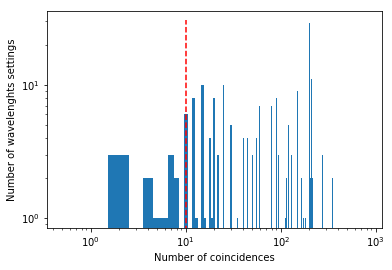

In [3]:
plt.hist(df['c'], bins=np.linspace(-0.5, 800.5, 801))
plt.xlabel('Number of coincidences')
plt.ylabel('Number of wavelenghts settings')
plt.plot(2*[10], plt.ylim(), 'r--')
plt.xscale('log')
plt.yscale('log')
nThr = 15
print 'Discading measurments with less than {} coincidences'
print 'Survival effiiency: {:.1f}%'.format(100*np.sum(df['c'] >= nThr)/float(df.shape[0]))
df = df[df['c'] >= nThr]

Text(0,0.5,'Signal wavelength [nm]')

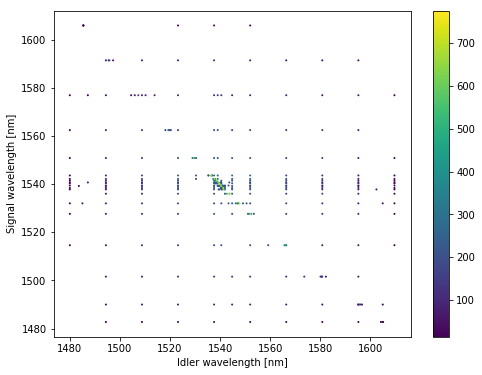

In [4]:
fig = plt.figure(figsize=(8,6))
sc = plt.scatter(df['idler'],df['signal'], facecolors=None,c=df['c'],cmap = 'viridis', s = 1, alpha = 1)
plt.colorbar(sc,ax = plt.gca())
plt.xlabel('Idler wavelength [nm]')
plt.ylabel('Signal wavelength [nm]')

Text(0.5,0,'$\\Delta\\lambda$(idler, signal) [nm]')

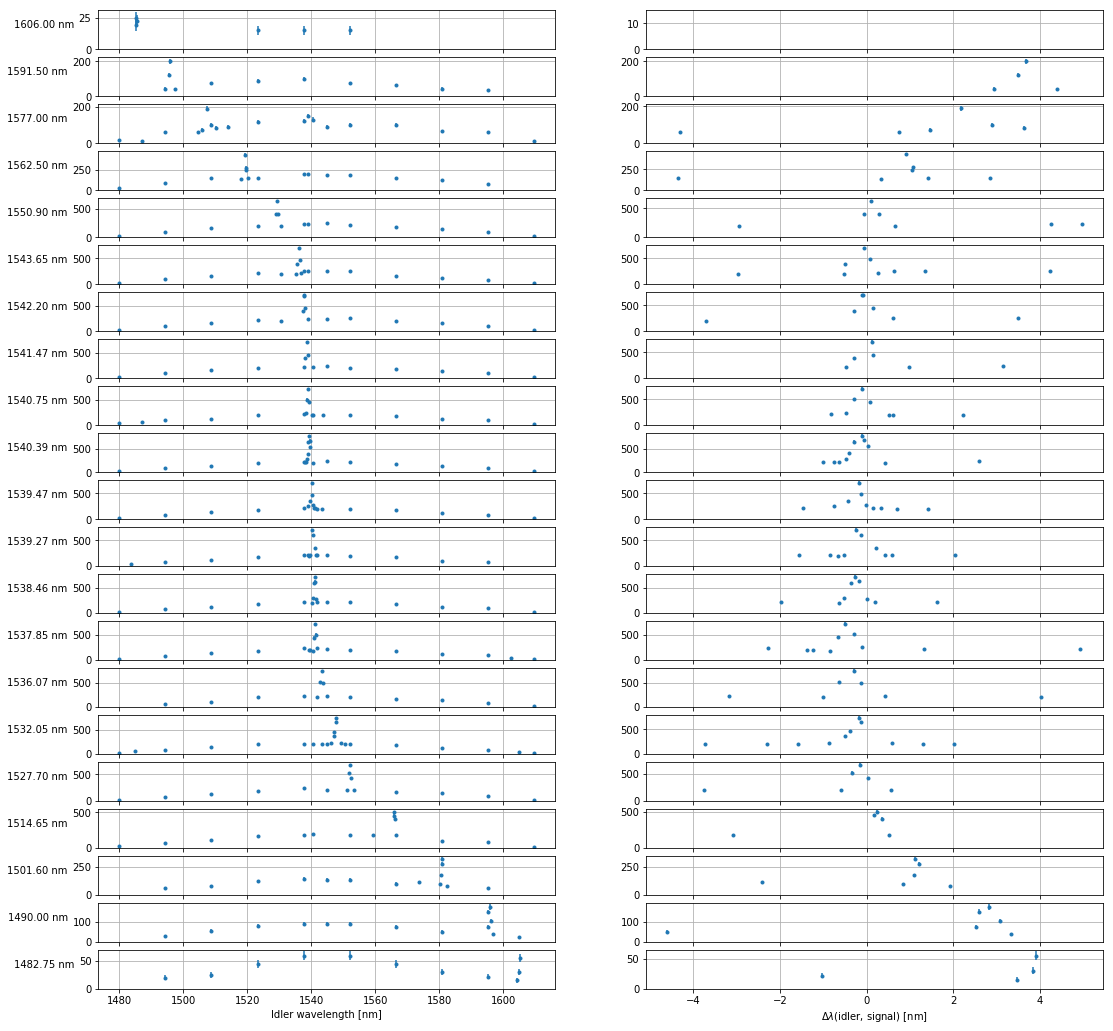

In [5]:
w_sig = np.sort(df['signal'].unique())
fig, axs = plt.subplots(w_sig.shape[0], 2, sharex='col', figsize=(18,18))

for i, ws in enumerate(reversed(w_sig)):
    auxDf = df[df['signal'] == ws]
    axs[i, 0].errorbar(auxDf['idler'], auxDf['c'], yerr=np.sqrt(auxDf['c']), 
                    marker='.', ls='none')
    axs[i, 0].grid()
    axs[i, 0].set_ylim(0, max(axs[i, 0].get_ylim()[1], 15) )
    axs[i, 0].set_ylabel('{:.2f} nm'.format(ws), rotation=0, labelpad=35)
    
    x = 0.5*(auxDf['idler'] + ws) - 1540
    sel = np.abs(x) < 5
    axs[i, 1].errorbar(x[sel], auxDf['c'][sel], yerr=np.sqrt(auxDf['c'])[sel], 
                    marker='.', ls='none')
    axs[i, 1].set_ylim(0, max(axs[i, 1].get_ylim()[1], 15) )
    axs[i, 1].grid()
axs[-1, 0].set_xlabel('Idler wavelength [nm]')
axs[-1, 1].set_xlabel(r'$\Delta\lambda$(idler, signal) [nm]')

# Model Fitting

In [6]:
from JSI_decomposition_utils import joint_spectrum
# def joint_spectrum(w_idler, w_signal, gamma, A, sigma_d=53., w_central=1540., sigma_p=0.03)

In [43]:
dfFit = df[df['c'] > 50]
dfFit = dfFit[dfFit['signal'] < 1590.]
dfFit = dfFit[dfFit['signal'] < 1560.]
dfFit = dfFit[dfFit['signal'] > 1491.]

x = 0.5*(dfFit['idler'] + dfFit['signal']) - 1540
dfFit = dfFit[np.abs(x) < 2]

# for ws in dfFit['signal'].unique():
#     isMax = dfFit['c'] == np.max(dfFit[dfFit['signal'] == ws]['c'])
#     aux = np.logical_and(dfFit['signal'] == ws, isMax)
#     sel = np.logical_or(dfFit['signal'] != ws, aux)
#     dfFit = dfFit[sel]

In [44]:
fit_res = {}
x_vec = dfFit[['idler', 'signal']].to_numpy()
y_vec = dfFit['c'].to_numpy()
y_err = np.hypot(np.sqrt(y_vec), 0.05*y_vec)

In [45]:
fit_res['sam'] = [[5.829e-7,11678008.66]]

In [46]:
def model(M, *args):
    x, y = M[:,0], M[:,1]
    return joint_spectrum(x,y,*args)

gamma = 0
A = 7.5e6
p_guess=[gamma, A]

params, pcov = sp_curve_fit(model, x_vec, y_vec, p_guess, sigma=y_err)
fit_res['base'] = [params, pcov]
Gamma_hat = params[0]
print 'Gamma: {:.1f} +/- {:.1f} 1/m'.format(Gamma_hat*1e9, 1e9*np.sqrt(pcov[0, 0]))

chi2 = np.sum(np.square((y_vec - model(x_vec, *params))/y_err))
dof = y_vec.shape[0] - params.shape[0]
print 'Chi2/dof: {:.0f}/{:.0f}'.format(chi2, dof)

Gamma: 543.6 +/- 93.0 1/m
Chi2/dof: 5014/99


In [47]:
def model(M, *args):
    gamma = fit_res['base'][0][0] + np.sqrt(fit_res['base'][1][0, 0])
    A = args[0]
    sigma_d = 53.
    w_central = 1540.
    x, y = M[:,0], M[:,1]
    return joint_spectrum(x,y,gamma,A,sigma_d,w_central)

A = 7.5e6
p_guess=[A]

params, pcov = sp_curve_fit(model, x_vec, y_vec, p_guess, sigma=y_err)
gamma = fit_res['base'][0][0] + np.sqrt(fit_res['base'][1][0, 0])
fit_res['gammaUp'] = [[gamma, params[0]], pcov]

In [48]:
def model(M, *args):
    gamma = fit_res['base'][0][0] - np.sqrt(fit_res['base'][1][0, 0])
    A = args[0]
    sigma_d = 53.
    w_central = 1540.
    x, y = M[:,0], M[:,1]
    return joint_spectrum(x,y,gamma,A,sigma_d,w_central)

A = 7.5e6
p_guess=[A]

params, pcov = sp_curve_fit(model, x_vec, y_vec, p_guess, sigma=y_err)
gamma = fit_res['base'][0][0] - np.sqrt(fit_res['base'][1][0, 0])
fit_res['gammaDw'] = [[gamma, params[0]], pcov]

In [49]:
def model(M, *args):
    gamma = args[0]
    A = args[1]
    sigma_d = args[2]
    w_central = 1540.
    x, y = M[:,0], M[:,1]
    return joint_spectrum(x,y,gamma,A,sigma_d,w_central)

A = 7.5e6
p_guess=[0, A, 53.]

params, pcov = sp_curve_fit(model, x_vec, y_vec, p_guess, sigma=y_err)
fit_res['sigma_d'] = [params, pcov]
print 'Gamma: {:.1f} +/- {:.1f} 1/m'.format(params[0]*1e9, 1e9*np.sqrt(pcov[0, 0]))
print 'sigma_d: {:.1f} +/- {:.1f} nm'.format(params[2], np.sqrt(pcov[2, 2]))

Gamma: 543.7 +/- 93.9 1/m
sigma_d: 53.1 +/- 7.8 nm


In [50]:
# def model(M, *args):
#     gamma = args[0]
#     A = args[1]
#     sigma_d = args[2]
#     w_central = 1540.
#     sigma_p = args[3]
#     x, y = M[:,0], M[:,1]
#     return joint_spectrum(x,y,gamma,A,sigma_d,w_central, sigma_p)

# A = 7.5e6
# p_guess=[0, A, 53., 0.03]

# params, pcov = sp_curve_fit(model, x_vec, y_vec, p_guess, sigma=y_err)
# fit_res['all'] = [params, pcov]
# print 'Gamma: {:.1f} +/- {:.1f} 1/m'.format(params[0]*1e9, 1e9*np.sqrt(pcov[0, 0]))
# print 'sigma_d: {:.1f} +/- {:.1f} nm'.format(params[2], np.sqrt(pcov[2, 2]))
# print 'sigma_p: {:.1f} +/- {:.1f} nm'.format(params[3], np.sqrt(pcov[3, 3]))

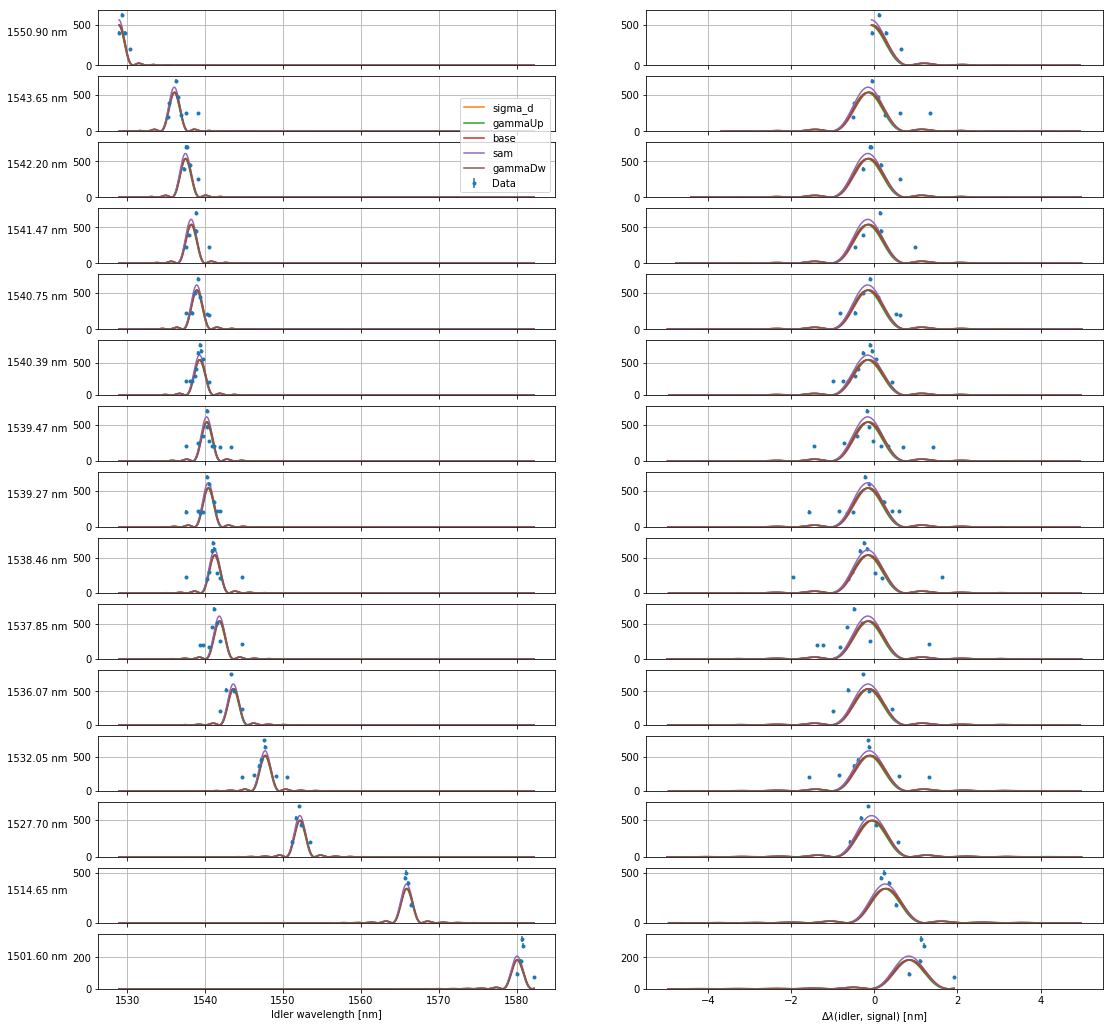

In [51]:
w_sig = np.sort(dfFit['signal'].unique())
fig, axs = plt.subplots(w_sig.shape[0], 2, sharex='col', figsize=(18,18))

w_idler_test = np.linspace( np.min(dfFit['idler']), np.max(dfFit['idler']), 500 )

for i, ws in enumerate(reversed(w_sig)):
    auxDf = dfFit[dfFit['signal'] == ws]
    axs[i, 0].errorbar(auxDf['idler'], auxDf['c'], yerr=np.sqrt(auxDf['c']), 
                    marker='.', ls='none', label='Data')
    
    for k, fr in fit_res.iteritems():
        y_hat = joint_spectrum(w_idler_test, ws, *(fr[0]))
        axs[i, 0].plot(w_idler_test, y_hat, label=k)
    
    axs[i, 0].grid()
    axs[i, 0].set_ylim(0, max(axs[i, 0].get_ylim()[1], 15) )
    axs[i, 0].set_ylabel('{:.2f} nm'.format(ws), rotation=0, labelpad=35)
    
    
    x = 0.5*(auxDf['idler'] + ws) - 1540
    sel = np.abs(x) < 5
    axs[i, 1].errorbar(x[sel], auxDf['c'][sel], yerr=np.sqrt(auxDf['c'])[sel], 
                    marker='.', ls='none')
    
    x = 0.5*(w_idler_test + ws) - 1540
    sel = np.abs(x) < 5
    for k, fr in fit_res.iteritems():
        y_hat = joint_spectrum(w_idler_test, ws, *(fr[0]))
        axs[i, 1].errorbar(x[sel], y_hat[sel])
    
    axs[i, 1].set_ylim(0, max(axs[i, 1].get_ylim()[1], 15) )
    axs[i, 1].grid()
axs[-1, 0].set_xlabel('Idler wavelength [nm]')
axs[-1, 1].set_xlabel(r'$\Delta\lambda$(idler, signal) [nm]')
axs[2,0].legend(loc='best')

# Schmidt decomposition

In [52]:
from JSI_decomposition_utils import joint_spectrum, cwdm_profile
# joint_spectrum(w_idler, w_signal, gamma, A, sigma_d=53., w_central=1540., sigma_p=0.03)
# cwdm_profile(x, y, sigma_x=13., sigma_y=13.)

In [53]:
def schmidt_decomposition(gamma, A, 
                          sigma_d=53., w_central=1540., 
                          sigma_x=13., sigma_y=13., 
                          nPoints=1000, 
                          nEig=60,
                          verbose=False):
    w_arr = np.linspace(1480, 1610, nPoints)
    w_grid = np.transpose([np.tile(w_arr, nPoints), np.repeat(w_arr[::-1], nPoints)]).reshape((nPoints, nPoints,2))
    
    JSI_mat = joint_spectrum(w_grid[:,:,0], w_grid[:,:,1], gamma, A, sigma_d, w_central)
    cwdm_mat = cwdm_profile(w_grid[:,:,0], w_grid[:,:,1], sigma_x, sigma_y)

    JSI_cwdm_mat = JSI_mat*cwdm_mat
    JSI_cwdm_mat = JSI_cwdm_mat*np.max(JSI_mat)/np.max(JSI_cwdm_mat)

    u_cwdm, s_cwdm, vh_cwdm = np.linalg.svd(JSI_cwdm_mat)
    svd_cwdm = s_cwdm/np.sum(s_cwdm)

    K_cwdm = 1. / np.sum(np.square(svd_cwdm))
    if verbose:
        print 'K cwdm: {:.1f}'.format(K_cwdm)
        plt.figure()
        plt.matshow(JSI_cwdm_mat)
        
        plt.figure()
        plt.bar(np.arange(nEig), svd_cwdm[:nEig], color='g', alpha=0.5, )
        plt.xlabel("Index (s)")
        plt.ylabel(r"Eigenvalues $\lambda_s$")
        plt.title("Schmidt Decomposition")
    return K_cwdm, svd_cwdm[:nEig]

K cwdm: 33.7


<Figure size 432x288 with 0 Axes>

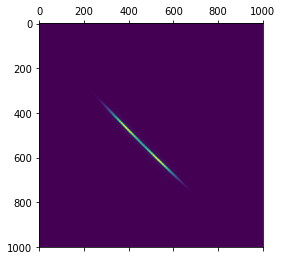

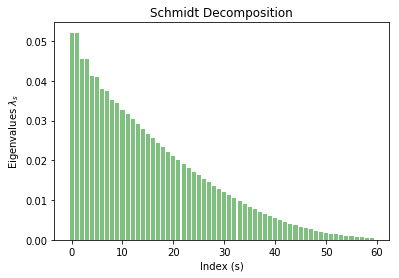

In [54]:
K_base, svd_base = schmidt_decomposition(*(fit_res['base'][0]), verbose=True);

In [55]:
schmidt_eig = pd.DataFrame()
schmidt_eig['central'] = svd_base

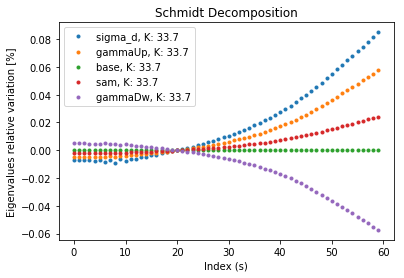

In [56]:
fitsToPlot = ['sam', 'gammaUp', 'gammaDw', 'all']
for k, fr in fit_res.iteritems():
    K_cwdm, svd_cwdm = schmidt_decomposition(*(fr[0]))
    plt.plot(np.arange(svd_cwdm.shape[0]), 100*(svd_cwdm-svd_base)/svd_base, '.', label=k+', K: {:.1f}'.format(K_cwdm))
    
plt.xlabel("Index (s)")
plt.ylabel('Eigenvalues relative variation [%]')
plt.title("Schmidt Decomposition")
plt.legend(loc='best')

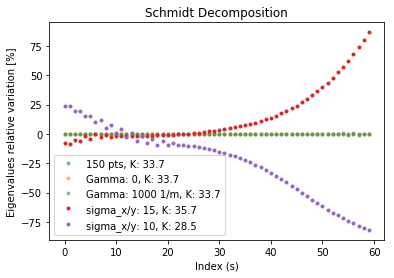

In [60]:
gamma, A = fit_res['base'][0]
K_cwdm, svd_cwdm = schmidt_decomposition(gamma, A, nPoints=150)
plt.plot(np.arange(svd_cwdm.shape[0]), 100*(svd_cwdm-svd_base)/svd_base, '.', alpha=0.5, label='150 pts, K: {:.1f}'.format(K_cwdm))

K_cwdm, svd_cwdm = schmidt_decomposition(0, A)
plt.plot(np.arange(svd_cwdm.shape[0]), 100*(svd_cwdm-svd_base)/svd_base, '.', alpha=0.5, label='Gamma: 0, K: {:.1f}'.format(K_cwdm))

K_cwdm, svd_cwdm = schmidt_decomposition(1e-6, A)
plt.plot(np.arange(svd_cwdm.shape[0]), 100*(svd_cwdm-svd_base)/svd_base, '.', alpha=0.5, label='Gamma: 1000 1/m, K: {:.1f}'.format(K_cwdm))

K_cwdm, svd_cwdm = schmidt_decomposition(gamma, A, sigma_x=15. , sigma_y=15.)
plt.plot(np.arange(svd_cwdm.shape[0]), 100*(svd_cwdm-svd_base)/svd_base, '.', label='sigma_x/y: 15, K: {:.1f}'.format(K_cwdm))
schmidt_eig['sigma_xy_Up'] = svd_cwdm

K_cwdm, svd_cwdm = schmidt_decomposition(gamma, A, sigma_x=10. , sigma_y=10.)
plt.plot(np.arange(svd_cwdm.shape[0]), 100*(svd_cwdm-svd_base)/svd_base, '.', label='sigma_x/y: 10, K: {:.1f}'.format(K_cwdm))
schmidt_eig['sigma_xy_Dw'] = svd_cwdm
    
plt.xlabel("Index (s)")
plt.ylabel('Eigenvalues relative variation [%]')
plt.title("Schmidt Decomposition")
plt.legend(loc='best')

In [22]:
schmidt_eig.to_csv('../data/schmidt_eigenvalues.csv')

In [59]:
gamma

5.436196031262623e-07